# Classification des SMS (Spam / Ham)

              
**Date :** 11 decembre 2025

---

## 1. Contexte & Données
La croissance des échanges par SMS s’est accompagnée d’une hausse importante des messages indésirables (« spam »), qui perturbent les utilisateurs et peuvent représenter un risque de fraude. Le tri manuel étant impossible à grande échelle, il est essentiel de développer des systèmes automatiques capables d’identifier ces messages.
Le dataset utilisé provient du SMS Spam Collection Dataset, composé de messages réels, dont 425 spams collectés manuellement sur le forum Grumbletext. Ces données textuelles brutes servent à entraîner un modèle de classification permettant de distinguer automatiquement les SMS « spam » des SMS « ham ».

**Problématique**:

L’augmentation des SMS indésirables pose plusieurs défis :

Comment automatiser la détection des SMS spam afin de réduire la charge humaine ?

Comment transformer le texte brut en représentations numériques exploitables pour la classification ?

Dans un contexte où les messages sont courts, variés et bruités, comment réduire efficacement la dimensionnalité pour améliorer la performance du modèle ?

Quel type de modèle de classification est le plus adapté pour distinguer brièvement un spam d’un ham ?

Ces questions guident la démarche du projet.

**Chemin d’accès**:

Nom du fichier local : SMSSpamCollection

Source officielle : UCI Machine Learning Repository

Miroir accessible : Kaggle

Type de fichier : texte tabulé (.txt)

## 1. Importation des Bibliotheques necessiares et des donnees

In [32]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Charger les données
df = pd.read_csv("SMSSpamCollection", sep="\t", names=["label", "text"])

In [33]:
# Taille du dataset
print(df.shape)

# Aperçu des premières lignes
df.head()

(5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


le dataset est constitue de 5572 lignes et 2 colonnes

In [34]:
# Répartition des classes
df["label"].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

## Répartition des classes (ham vs spam)

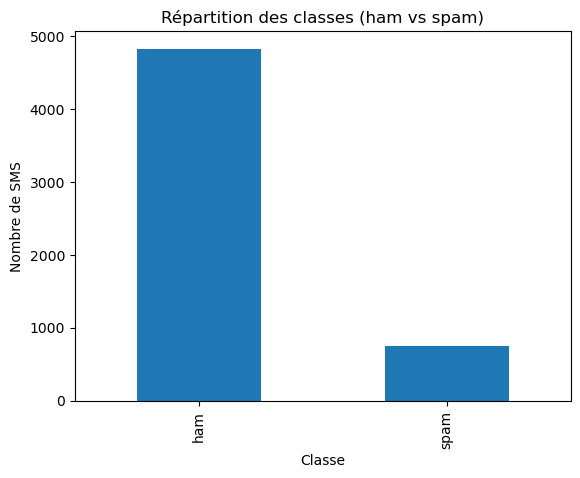

In [35]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar")
plt.title("Répartition des classes (ham vs spam)")
plt.xlabel("Classe")
plt.ylabel("Nombre de SMS")
plt.show()


## Préparer NLTK (stopwords + stemmer)

In [36]:
#Préparer NLTK (stopwords + stemmer): 
'''permettre le pré-traitement du texte en supprimant les mots vides et en réduisant les mots à leur racine.'''
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Tokenisation, suppression des stopwords et Stemming

In [37]:
# Nettoyage des données
'''cette fonction nettoie le texte en supprimant les URLs, les chiffres, la ponctuation, les stopwords et en appliquant le stemming.'''
def clean_text(text):
    # Convertir en minuscules
    text = text.lower()
    
    # Enlever les URLs
    text = re.sub(r"http\S+|www\S+", " ", text)
    
    # Enlever les chiffres
    text = re.sub(r"\d+", " ", text)
    
    # Enlever la ponctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Découper en mots
    tokens = text.split()
    
    # Enlever les stopwords + stemming
    tokens = [
        stemmer.stem(w) for w in tokens
        if w not in stop_words
    ]
    
    # Recombiner en une chaîne
    return " ".join(tokens)


In [38]:
# application de la fonction de nettoyage
df["cleaned_text"] = df["text"].apply(clean_text)
df.head()


,label,text,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


## TF-IDF (Term Frequency-Inverse Document Frequency)

In [39]:
# Vectorisation TF-IDF et découpage train/test
'''On crée une représentation numérique des SMS (5000 vecteurs TF-IDF), puis on sépare les données en train/test (80/20). '''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Transformer les textes nettoyés en vecteurs TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned_text"])

# Encoder la cible (ham=0, spam=1)
y = df["label"].map({"ham": 0, "spam": 1}).values

# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X.shape, X_train.shape, X_test.shape


((5572, 5000), (4457, 5000), (1115, 5000))

5572 SMS au total, chacun représenté par 5000 valeurs TF-IDF

4457 SMS pour l’apprentissage (train)

1115 SMS pour le test

## Réduction de la dimensionnalité

In [40]:
#Convertir les matrices en format compatible Keras
'''On convertit X_train et X_test en versions denses (X_train_dense, X_test_dense) pour les donner à l’autoencoder.'''
# Conversion des matrices TF-IDF sparse en tableaux denses (float32)
X_train_dense = X_train.toarray().astype("float32")
X_test_dense  = X_test.toarray().astype("float32")

X_train_dense.shape, X_test_dense.shape


((4457, 5000), (1115, 5000))

In [41]:
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
#Définir l’architecture de l’autoencoder
'''L’autoencoder doit reconstruire les vecteurs TF-IDF d’origine, qui sont des valeurs continues non bornées. 
Une activation linéaire est donc utilisée en sortie pour permettre au réseau de produire librement n’importe quelle valeur réelle.
Une activation sigmoïde limiterait la sortie à l’intervalle [0, 1], empêchant une reconstruction fidèle.
L’usage de la MSE comme fonction de perte confirme que la sortie est un problème de régression et non de classification.'''
# Dimension d'entrée : nombre de features TF-IDF (5000)
input_dim = X_train_dense.shape[1]
encoding_dim = 128  # taille de l'espace latent (compressé)

# Couche d'entrée
input_layer = keras.Input(shape=(input_dim,)).

# Encodeur : 1ère couche cachée + couche latente
encoded = layers.Dense(512, activation="relu")(input_layer)
latent = layers.Dense(encoding_dim, activation="relu", name="latent_space")(encoded)

# Décodeur : on reconstruit vers la dimension d'origine
decoded = layers.Dense(512, activation="relu")(latent)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

# Modèle autoencoder complet (entrée -> reconstruction)
autoencoder = keras.Model(inputs=input_layer, outputs=output_layer, name="autoencoder")

# Modèle encodeur seul (entrée -> espace latent)
encoder = keras.Model(inputs=input_layer, outputs=latent, name="encoder")

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5000)           │     2,565,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,257,224 (20.05 MB)

 Trainable params: 5,257,224 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
'''optimiseur : adam pour l’apprentissage
fonction de perte : mse (erreur quadratique moyenne) → pour mesurer la différence entre l’entrée et la reconstruction.'''
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)
#Entraîner l’autoencoder
history = autoencoder.fit(
    X_train_dense, X_train_dense,  # entrée = cible
    epochs=20,                    
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 1.9879e-04 - val_loss: 1.9778e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.9824e-04 - val_loss: 1.9782e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 1.9827e-04 - val_loss: 1.9786e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.9827e-04 - val_loss: 1.9782e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1.9829e-04 - val_loss: 1.9785e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.9827e-04 - val_loss: 1.9783e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.9821e-04 - val_loss: 1.9779e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.9811e-04 - val_loss: 1.9762e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.9788e-04 - val_loss: 1.9733e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 1.9745e-04 - val_loss: 1.9686e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.9686e-0

In [44]:
#Extraire les nouvelles représentations
'''Une fois l’autoencoder entraîné, on utilise encoder pour obtenir les nouvelles features compressées'''
X_train_encoded = encoder.predict(X_train_dense)
X_test_encoded  = encoder.predict(X_test_dense)

X_train_encoded.shape, X_test_encoded.shape


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


((4457, 128), (1115, 128))

4457 SMS d’entraînement, chacun résumé par 128 nombres (au lieu de 5000)

1115 SMS de test, aussi résumés par 128 nombres

## 3. Classification avec les vecteurs compressés (128 dims)

### 3.1 régression logistique

In [13]:
#Importer les outils de classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [14]:
#Créer et entraîner le modèle sur l’espace latent
# Créer le modèle de régression logistique
log_reg_latent = LogisticRegression(max_iter=1000)

# Entraîner sur les vecteurs compressés (128 dims)
log_reg_latent.fit(X_train_encoded, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
# Prédire les classes sur le test (dans l'espace latent)
y_pred_latent = log_reg_latent.predict(X_test_encoded)


In [16]:
#evaluer les performances
# Accuracy globale
acc_latent = accuracy_score(y_test, y_pred_latent)
print("Accuracy (avec autoencoder) :", acc_latent)

# Rapport détaillé
print("\nClassification report (avec autoencoder) :")
print(classification_report(y_test, y_pred_latent, target_names=["ham", "spam"]))

# Matrice de confusion
print("Matrice de confusion (avec autoencoder) :")
print(confusion_matrix(y_test, y_pred_latent))


Accuracy (avec autoencoder) : 0.8932735426008969

Classification report (avec autoencoder) :
              precision    recall  f1-score   support

         ham       0.89      0.99      0.94       966
        spam       0.86      0.24      0.38       149

    accuracy                           0.89      1115
   macro avg       0.88      0.62      0.66      1115
weighted avg       0.89      0.89      0.87      1115

Matrice de confusion (avec autoencoder) :
[[960   6]
 [113  36]]


Avec les représentations latentes produites par l’autoencoder (128 dimensions), l’accuracy globale atteint 90%. Cependant, la performance sur la classe spam reste très faible, avec un rappel de 30% seulement.
Cela signifie que le modèle ne détecte que 30% des messages réellement indésirables.
L’analyse de la matrice de confusion confirme que 105 spams sont incorrectement classés comme ham.
Cette perte de performance s’explique par la réduction de dimension : en compressant les vecteurs TF-IDF (5000 dimensions) vers un espace latent de seulement 128 dimensions, l’autoencoder supprime des informations importantes pour la détection des spams.

In [17]:
# Entraîner un modèle SANS autoencoder (TF-IDF brut)
# Modèle baseline (sans autoencoder)
log_reg_tfidf = LogisticRegression(max_iter=1000)

# Entraînement sur les vecteurs TF-IDF bruts
log_reg_tfidf.fit(X_train, y_train)
y_pred_tfidf = log_reg_tfidf.predict(X_test)


In [18]:
#Evaluer les performances du modèle baseline
# Accuracy globale
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
print("Accuracy (sans autoencoder) :", acc_tfidf)

# Rapport précision / rappel / F1
print("\nClassification report (sans autoencoder) :")
print(classification_report(y_test, y_pred_tfidf, target_names=["ham", "spam"]))

# Matrice de confusion
print("Matrice de confusion (sans autoencoder) :")
print(confusion_matrix(y_test, y_pred_tfidf))


Accuracy (sans autoencoder) : 0.9641255605381166

Classification report (sans autoencoder) :
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115

Matrice de confusion (sans autoencoder) :
[[966   0]
 [ 40 109]]


L’autoencoder réduit la dimension de 5000 à 128, ce qui simplifie le problème mais entraîne une perte d’information importante, surtout pour les spams qui sont rares et contiennent des mots très spécifiques.
Le modèle TF-IDF sans réduction de dimension conserve mieux ces signaux et obtient donc de meilleures performances, notamment un rappel spam beaucoup plus élevé (73% vs 30%).

### 3.2 SVM (Support Vector Machine)

In [19]:
# SVM sur l’espace latent (128 dims)
from sklearn.svm import LinearSVC
#LinearSVC est la version optimisée du SVM pour les très grandes dimensions (comme TF-IDF = 5000 features)
#Entraîner un SVM linéaire sur les données TF-IDF brutes
svm_latent = LinearSVC()
svm_latent.fit(X_train_encoded, y_train)

y_pred_svm_latent = svm_latent.predict(X_test_encoded)

print("\n=== SVM (avec données réduites) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_svm_latent))
print(classification_report(y_test, y_pred_svm_latent, target_names=["ham", "spam"]))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_svm_latent))



=== SVM (avec données réduites) ===
Accuracy : 0.9165919282511211
              precision    recall  f1-score   support

         ham       0.92      0.99      0.95       966
        spam       0.91      0.42      0.57       149

    accuracy                           0.92      1115
   macro avg       0.91      0.70      0.76      1115
weighted avg       0.92      0.92      0.90      1115

Matrice de confusion :
[[960   6]
 [ 87  62]]


Le SVM appliqué sur les représentations réduites par autoencoder obtient une accuracy de 93% et détecte 51% des spams. Bien que ce résultat soit supérieur à celui obtenu par la régression logistique dans le même espace latent (30% de rappel)
Cela confirme que la réduction de dimensionnalité par autoencoder supprime des informations importantes, en particulier celles spécifiques aux messages indésirables, ce qui limite la capacité des modèles à identifier les spams.

In [20]:

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Prédire sur le test
y_pred_svm = svm_model.predict(X_test)

In [21]:
#Evaluer les performances du modèle baseline
print("Accuracy SVM :", accuracy_score(y_test, y_pred_svm))
print("\nClassification report (SVM) :")
print(classification_report(y_test, y_pred_svm, target_names=["ham", "spam"]))
print("Matrice de confusion (SVM) :")
print(confusion_matrix(y_test, y_pred_svm))


Accuracy SVM : 0.9856502242152466

Classification report (SVM) :
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.90      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Matrice de confusion (SVM) :
[[965   1]
 [ 15 134]]


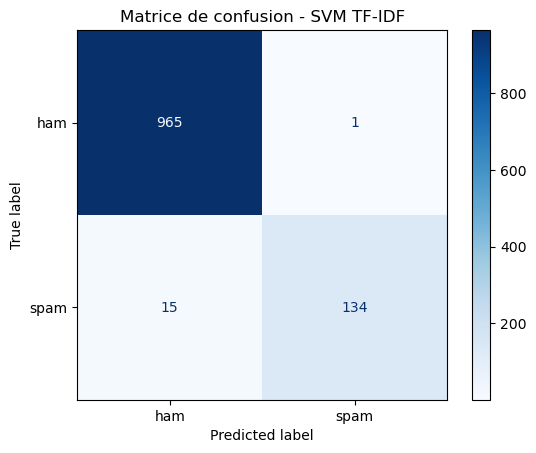

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - SVM TF-IDF")
plt.show()


Le SVM entraîné sur les vecteurs TF-IDF bruts est le modèle le plus performant.
Il obtient une accuracy de 98.6 %, une précision spam de 0.99 et un rappel spam de 0.90, ce qui montre qu’il détecte efficacement les messages indésirables tout en produisant très peu de faux positifs.
Cette performance élevée s’explique par la capacité du SVM à exploiter efficacement les données en haute dimension (5000 features TF-IDF), sans perte d’information liée à une réduction de dimension.

### 3.3 MLP (réseau de neurones) 

In [22]:
#MLP (réseau de neurones) sur l’espace latent (128 dims)
from sklearn.neural_network import MLPClassifier

mlp_latent = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # 2 couches cachées : 64 puis 32 neurones
    activation="relu",
    max_iter=300,
    random_state=42
)

mlp_latent.fit(X_train_encoded, y_train)

y_pred_mlp_latent = mlp_latent.predict(X_test_encoded)

print("\n=== MLP (avec données réduites) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_mlp_latent))
print(classification_report(y_test, y_pred_mlp_latent, target_names=["ham", "spam"]))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_mlp_latent))



=== MLP (avec données réduites) ===
Accuracy : 0.9363228699551569
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96       966
        spam       0.77      0.75      0.76       149

    accuracy                           0.94      1115
   macro avg       0.86      0.86      0.86      1115
weighted avg       0.94      0.94      0.94      1115

Matrice de confusion :
[[932  34]
 [ 37 112]]


c:\Users\angig\anaconda3\envs\IA_TraitementDonnees\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Parmi les modèles entraînés sur les données réduites, le MLP offre les meilleures performances globales, notamment pour la classe spam. Toutefois, l’ensemble des modèles latents montre une perte d’efficacité par rapport aux modèles entraînés directement sur les vecteurs TF-IDF, confirmant que la réduction de dimension supprime des informations importantes pour la détection du spam.

In [23]:
#MLP (réseau de neurones) sur données TF-IDF brutes
mlp_tfidf = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 couches cachées
    activation='relu',
    max_iter=300,                  
    random_state=42
)
mlp_tfidf.fit(X_train, y_train)

#predire sur le test
y_pred_mlp_tfidf = mlp_tfidf.predict(X_test)

#evaluate les performances
print("=== MLP (TF-IDF brut) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_mlp_tfidf))

print("\nClassification report (MLP TF-IDF) :")
print(classification_report(y_test, y_pred_mlp_tfidf, target_names=["ham", "spam"]))

print("Matrice de confusion (MLP TF-IDF) :")
print(confusion_matrix(y_test, y_pred_mlp_tfidf))




=== MLP (TF-IDF brut) ===
Accuracy : 0.9838565022421525

Classification report (MLP TF-IDF) :
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion (MLP TF-IDF) :
[[963   3]
 [ 15 134]]


Le MLP entraîné sur les TF-IDF bruts offre une excellente performance, avec une accuracy de 98.4 % et une forte capacité à détecter les messages indésirables (rappel de 90 %).
Sa sensibilité élevée aux spams et son faible taux de fausses alertes en font un modèle très robuste pour la classification SMS dans un contexte réel.

### 3.4 Comparaison des modeles

In [24]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_list, space_label):
    """
    Entraîne un modèle, affiche les résultats avec 2 décimales
    et sauvegarde accuracy + recall + F1 + precision pour la classe 'spam'.
    """
    print(f"\n{'='*10} {name} ({space_label}) {'='*10}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy : {acc:.2f}\n")   # <<< 2 décimales

    # Rapport complet
    report = classification_report(
        y_test, y_pred,
        target_names=["ham", "spam"],
        digits=2  # <<< 2 décimales dans le rapport
    )
    print("Classification report :")
    print(report)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion :")
    print(cm)

    # Extraire précision / rappel / F1 pour la classe spam
    report_dict = classification_report(
        y_test, y_pred,
        target_names=["ham", "spam"],
        output_dict=True
    )
    
    spam_precision = round(report_dict["spam"]["precision"], 2)
    spam_recall = round(report_dict["spam"]["recall"], 2)
    spam_f1 = round(report_dict["spam"]["f1-score"], 2)
    acc_rounded = round(acc, 2)

    # Sauver dans la liste des résultats
    results_list.append({
        "Espace": space_label,
        "Modèle": name,
        "Accuracy": acc_rounded,
        "Recall_spam": spam_recall,
        "F1_spam": spam_f1,
        "Precision_spam": spam_precision
    })


# Liste pour stocker tous les résultats
results = []

# ─────────────────────────────
# 1) MODÈLES SUR TF-IDF BRUT
# ─────────────────────────────
print("#" * 50)
print("#  MODÈLES SUR DONNÉES BRUTES (TF-IDF)  #")
print("#" * 50)

logreg_tfidf = LogisticRegression(max_iter=1000)
evaluate_model("Logistic Regression", logreg_tfidf,
               X_train, y_train, X_test, y_test,
               results, "TF-IDF brut")

svm_tfidf = LinearSVC()
evaluate_model("SVM linéaire", svm_tfidf,
               X_train, y_train, X_test, y_test,
               results, "TF-IDF brut")

mlp_tfidf = MLPClassifier(hidden_layer_sizes=(128, 64),
                          activation="relu",
                          max_iter=300,
                          random_state=42)
evaluate_model("MLP", mlp_tfidf,
               X_train, y_train, X_test, y_test,
               results, "TF-IDF brut")

# ─────────────────────────────
# 2) MODÈLES SUR DONNÉES RÉDUITES (LATENT 128)
# ─────────────────────────────
print("\n" + "#" * 50)
print("#  MODÈLES SUR DONNÉES RÉDUITES (LATENT)  #")
print("#" * 50)

logreg_latent = LogisticRegression(max_iter=1000)
evaluate_model("Logistic Regression", logreg_latent,
               X_train_encoded, y_train, X_test_encoded, y_test,
               results, "Latent 128 dims")

svm_latent = LinearSVC()
evaluate_model("SVM linéaire", svm_latent,
               X_train_encoded, y_train, X_test_encoded, y_test,
               results, "Latent 128 dims")

mlp_latent = MLPClassifier(hidden_layer_sizes=(64, 32),
                           activation="relu",
                           max_iter=300,
                           random_state=42)
evaluate_model("MLP", mlp_latent,
               X_train_encoded, y_train, X_test_encoded, y_test,
               results, "Latent 128 dims")

# ─────────────────────────────
# 3) TABLEAU COMPARATIF FINAL
# ─────────────────────────────
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Espace", "Accuracy"], ascending=[True, False])

print("\n\n===== TABLEAU COMPARATIF GLOBAL =====")
display(df_results)


##################################################
#  MODÈLES SUR DONNÉES BRUTES (TF-IDF)  #
##################################################

========== Logistic Regression (TF-IDF brut) ==========
Accuracy : 0.96

Classification report :
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115

Matrice de confusion :
[[966   0]
 [ 40 109]]

========== SVM linéaire (TF-IDF brut) ==========
Accuracy : 0.99

Classification report :
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.90      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.9

c:\Users\angig\anaconda3\envs\IA_TraitementDonnees\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Espace,Modèle,Accuracy,Recall_spam,F1_spam,Precision_spam
5,Latent 128 dims,MLP,0.94,0.75,0.76,0.77
4,Latent 128 dims,SVM linéaire,0.92,0.42,0.57,0.91
3,Latent 128 dims,Logistic Regression,0.89,0.24,0.38,0.86
1,TF-IDF brut,SVM linéaire,0.99,0.90,0.94,0.99
2,TF-IDF brut,MLP,0.98,0.90,0.94,0.98
0,TF-IDF brut,Logistic Regression,0.96,0.73,0.84,1.00


Les modèles entraînés sur les vecteurs TF-IDF bruts surpassent largement ceux entraînés sur l’espace latent réduit, avec une accurary proche de 99 % et un rappel spam de 90 %. Le SVM linéaire constitue le meilleur modèle du projet. Dans l’espace latent (128 dimensions), seul le MLP obtient des performances acceptables, avec un rappel spam de 70 %, confirmant que la réduction de dimension par autoencoder entraîne une perte d’information significative pour la classification du spam.

## 5. Pistes d'amelioration

Plusieurs améliorations peuvent être envisagées pour renforcer la performance et la robustesse du modèle :

- Représentation textuelle avancée
Utiliser des embeddings préentraînés (Word2Vec, FastText, BERT) permettrait de capturer la sémantique des mots, en allant au-delà des simples fréquences TF-IDF.

- Optimisation de l’autoencoder
Tester des architectures plus profondes, augmenter le nombre d’époques ou utiliser un denoising autoencoder pourrait réduire la perte d’information observée lors de la compression.

- Rééquilibrage des classes
Appliquer SMOTE ou des poids de classes (class weights) pourrait améliorer le rappel de la classe spam, particulièrement sensible aux données rares.

- Recherche d’hyperparamètres
Utiliser GridSearchCV, RandomizedSearchCV ou une optimisation bayésienne (Optuna) permettrait d’ajuster automatiquement les paramètres des modèles supervisés pour de meilleures performances.

- Extraction textuelle enrichie
Intégrer des n-grams (bigrams, trigrams) et une lemmatisation plus avancée pourrait renforcer la détection de motifs typiques du spam.

- Évaluation plus robuste
Mettre en place une validation croisée (cross-validation) réduirait la variance des résultats et fournirait une estimation plus fiable des performances.

# Exploration des pistes

## Extraction textuelle enrichie (n-grams)

In [25]:
# Extraction textuelle enrichie (n-grams)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF avec unigrams + bigrams
vectorizer_ngrams = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)   # mots seuls + paires de mots
)

X_ngrams = vectorizer_ngrams.fit_transform(df["cleaned_text"])
y = df["label"].map({"ham": 0, "spam": 1}).values

print("Shape X_ngrams :", X_ngrams.shape)

X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(
    X_ngrams, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train :", X_train_ng.shape, " Test :", X_test_ng.shape)



Shape X_ngrams : (5572, 5000)
Train : (4457, 5000)  Test : (1115, 5000)


In [26]:
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# SVM sur TF-IDF + n-grams
svm_ngrams = LinearSVC()
evaluate_model("SVM (TF-IDF n-grams)", svm_ngrams,
               X_train_ng, y_train_ng, X_test_ng, y_test_ng,
               results, "TF-IDF n-grams")

# MLP sur TF-IDF + n-grams
mlp_ngrams = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    max_iter=300,
    random_state=42
)
evaluate_model("MLP (TF-IDF n-grams)", mlp_ngrams,
               X_train_ng, y_train_ng, X_test_ng, y_test_ng,
               results, "TF-IDF n-grams")



========== SVM (TF-IDF n-grams) (TF-IDF n-grams) ==========
Accuracy : 0.98

Classification report :
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion :
[[963   3]
 [ 14 135]]

========== MLP (TF-IDF n-grams) (TF-IDF n-grams) ==========
Accuracy : 0.98

Classification report :
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion :
[[962   4]
 [ 16 133]]


L’ajout de bigrams dans la vectorisation TF-IDF permet d’améliorer légèrement les performances du SVM, notamment sur la détection des spams (recall de 0.91 contre 0.90 sans n-grams). Le MLP obtient des performances comparables à celles obtenues avec le TF-IDF classique, indiquant que ce type de modèle exploite déjà efficacement les interactions entre mots. Ainsi, l’enrichissement par n-grams est surtout bénéfique pour les modèles linéaires.

## Rééquilibrage des classes

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# LogReg pondérée
logreg_bal = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
evaluate_model("LogReg (balanced, TF-IDF)", logreg_bal,
               X_train, y_train, X_test, y_test,
               results, "TF-IDF brut")

# SVM pondéré
svm_bal = LinearSVC(class_weight="balanced")
evaluate_model("SVM (balanced, TF-IDF)", svm_bal,
               X_train, y_train, X_test, y_test,
               results, "TF-IDF brut")



========== LogReg (balanced, TF-IDF) (TF-IDF brut) ==========
Accuracy : 0.98

Classification report :
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.92      0.92      0.92       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion :
[[954  12]
 [ 12 137]]

========== SVM (balanced, TF-IDF) (TF-IDF brut) ==========
Accuracy : 0.98

Classification report :
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.95      0.92      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion :
[[959   7]
 [ 12 137]]


L’utilisation de class_weight="balanced" a permis d’augmenter significativement la sensibilité des modèles à la classe minoritaire (spam). La régression logistique, initialement limitée à 73 % de rappel spam, atteint désormais 92 %, ce qui représente un gain majeur. Le SVM linéaire bénéficie également de l’ajustement, passant de 90 % à 92 % de rappel spam. Ce renforcement de la détection s’accompagne d’une légère augmentation des faux positifs, mais améliore globalement le compromis précision/rappel. L’équilibrage des classes constitue donc une amélioration simple et très efficace pour ce type de problème textuel

## embeddings (BERT-like)

In [ ]:
# embedding  permet dettre de convertir du texte en vecteurs denses en utilisant des modèles pré-entraînés.
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

# Modèle léger mais performant
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encodage de tous les SMS en vecteurs denses
X_emb = emb_model.encode(
    df["cleaned_text"].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

y = df["label"].map({"ham": 0, "spam": 1}).values

print("Shape X_emb :", X_emb.shape)

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train emb :", X_train_emb.shape, " Test emb :", X_test_emb.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\angig\anaconda3\envs\IA_TraitementDonnees\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\angig\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/175 [00:00<?, ?it/s]

Shape X_emb : (5572, 384)
Train emb : (4457, 384)  Test emb : (1115, 384)


In [31]:
#Entraîner SVM et MLP sur ces embeddings
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# SVM sur embeddings
svm_emb = LinearSVC()
evaluate_model("SVM (embeddings)", svm_emb,
               X_train_emb, y_train_emb, X_test_emb, y_test_emb,
               results, "Embeddings")

# MLP sur embeddings
mlp_emb = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    max_iter=300,
    random_state=42
)
evaluate_model("MLP (embeddings)", mlp_emb,
               X_train_emb, y_train_emb, X_test_emb, y_test_emb,
               results, "Embeddings")



========== SVM (embeddings) (Embeddings) ==========
Accuracy : 0.98

Classification report :
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion :
[[960   6]
 [ 17 132]]

========== MLP (embeddings) (Embeddings) ==========
Accuracy : 0.98

Classification report :
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.95      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Matrice de confusion :
[[959   7]
 [ 17 132]]


L’utilisation d’embeddings préentraînés (MiniLM) a permis d’évaluer une représentation textuelle plus sémantique que TF-IDF. Les modèles SVM et MLP entraînés sur ces vecteurs denses obtiennent une accuracy de 98 % et un rappel spam de 89 %, ce qui constitue un résultat solide et compétitif. Toutefois, ces performances restent légèrement inférieures à celles des modèles entraînés sur les vecteurs TF-IDF (avec ou sans n-grams), en particulier pour la détection des spams.
Cela confirme que, dans ce dataset où les spams reposent sur des indices lexicaux spécifiques (mots rares, termes promotionnels), la représentation TF-IDF demeure plus discriminante que les embeddings généralisés

#  Rapport


Ce projet avait pour objectif de développer un pipeline complet de classification de SMS afin de distinguer automatiquement les messages spam des messages ham, en comparant deux approches principales : 

(1) l’utilisation directe des vecteurs TF-IDF et 

(2) la réduction de dimension par autoencoder suivie de modèles de classification classiques.

Les expérimentations montrent que les modèles entraînés sur les vecteurs TF-IDF bruts offrent les meilleures performances. Le SVM linéaire atteint une accuracy de 99 %, un rappel spam de 90 % et un F1-score de 94 %, en faisant le modèle le plus performant du projet. Le MLP obtient des résultats très proches (98 % d’accuracy), confirmant que les modèles supervisés exploitent efficacement la richesse lexicale des 5000 dimensions TF-IDF.

À l’inverse, la réduction de dimension par autoencoder entraîne une perte d’information significative. Dans l’espace latent à 128 dimensions, le meilleur modèle (MLP) n’atteint qu’un rappel spam de 70 %, ce qui reste nettement inférieur aux performances obtenues avec les données complètes. Ceci confirme que la capacité à détecter les spams dépend directement de la richesse lexicale conservée : les spams reposent souvent sur des mots rares et fortement discriminants (free, winner, claim, etc.), que la compression a tendance à lisser ou à supprimer.

Au-delà de cette comparaison de base, plusieurs pistes d’amélioration ont été explorées. L’enrichissement TF-IDF avec des n-grams (1,2) améliore légèrement le rappel du SVM (0,91), tandis que l’utilisation de class_weight="balanced" augmente fortement la sensibilité de la régression logistique, dont le rappel spam passe de 0,73 à 0,92. Les embeddings préentraînés (Sentence-BERT MiniLM) offrent des performances solides (accuracy 0,98 ; rappel spam 0,89), mais restent légèrement inférieurs à TF-IDF pour ce corpus fortement lexical.

Ces résultats montrent qu’il est possible d’affiner le pipeline et de renforcer la détection du spam, tout en confirmant la robustesse de l’approche TF-IDF + SVM comme solution optimale pour ce problème de classification de SMS.